# Learn with Linear Model

Use a linear model to learn weights for draco. 

In [23]:
from draco.learn import linear
from draco.learn import data_util
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data, _ = data_util.load_data(test_size=0.3)

In [3]:
# limit task
# data.task.hist()
# data= data[data.task == 'derived']

In [4]:
X = data.positive - data.negative
y = np.ones(len(X))

## Run Model and then PCA

We see 7 distinct clusters. What do they mean?

Train score:  0.9119420989143546


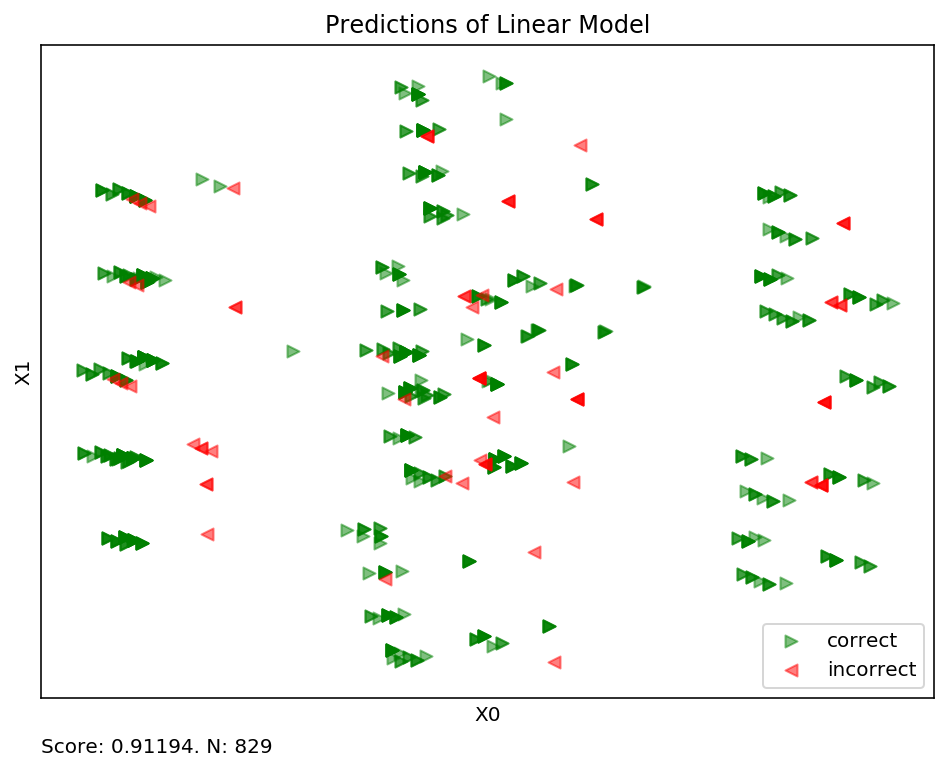

CPU times: user 964 ms, sys: 49.7 ms, total: 1.01 s
Wall time: 3.02 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [5]:
%time linear.train_and_plot(data, test_size=0)

## Try a different model (just for comparison)

In [6]:
print("Our approach")
linear.train_model(X, 0.3)
print()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_pair_train = np.concatenate((X_train, -X_train), axis=0)
y_pair_train = np.concatenate((y_train, -y_train), axis=0)

tree = DecisionTreeClassifier()
tree.fit(X_pair_train, y_pair_train)

print("Decision tree")
print("Train score: ", tree.score(X_pair_train,y_pair_train))
print("Dev score: ", tree.score(X_test,y_test))
print()


svm = SVC()
svm.fit(X_pair_train, y_pair_train)

print("Kernel SVM")
print("Train score: ", svm.score(X_pair_train,y_pair_train))
print("Dev score: ", svm.score(X_test,y_test))
print()

nn = MLPClassifier()
nn.fit(X_pair_train, y_pair_train)

print("Neural Net")
print("Train score: ", nn.score(X_pair_train,y_pair_train))
print("Dev score: ", nn.score(X_test,y_test))
print()

Our approach
Train score:  0.9155172413793103
Dev score:  0.9317269076305221

Decision tree
Train score:  0.9431034482758621
Dev score:  0.8514056224899599

Kernel SVM
Train score:  0.9
Dev score:  0.891566265060241

Neural Net
Train score:  0.9318965517241379
Dev score:  0.9036144578313253



From the looks of it, a non linear approach does not work better. Thus, we conclude:

1. We can’t put a non-linear back into the constraint system so that's no good.
2. Even if we could, it would be hard to understand the model.
3. And it also performs worse.

## Explain Variance

Try to explain the variance using principal components. It we can explain most of the variance with few components, then the clustering we see above should be meaningful. 

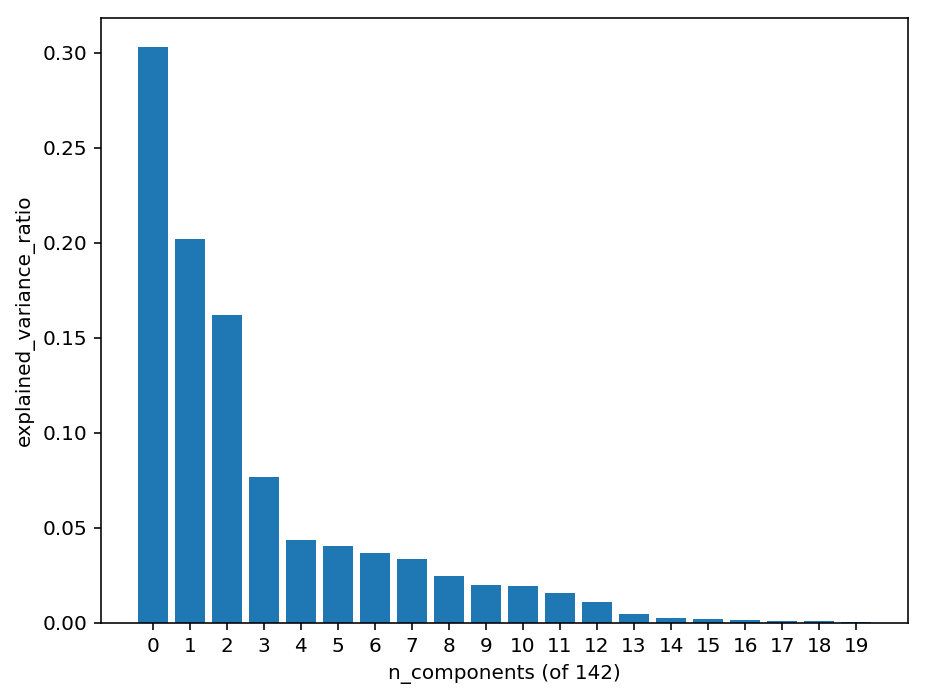

In [7]:
pca = PCA()
X2 = pca.fit_transform(X)

num_features = len(X.columns)
size = 20  # num_features

x = np.arange(size)

plt.figure(figsize=(8,6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.bar(x=x, height=pca.explained_variance_ratio_[:size])
plt.axis('tight')
plt.xlabel(f'n_components (of {num_features})')
plt.ylabel('explained_variance_ratio')
plt.xticks(x)

plt.show()

In [8]:
# number of componts as estimated by the PCA
pca.n_components_

142

## Model score to accuracy

In [9]:
clf = linear.train_model(X, 0)

Train score:  0.9119420989143546


In [10]:
df = pd.DataFrame(columns=['pred', 'score'], index=X.index)

df.pred = clf.predict(X)
df.score = clf.decision_function(X)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113008978>,
      dtype=object)

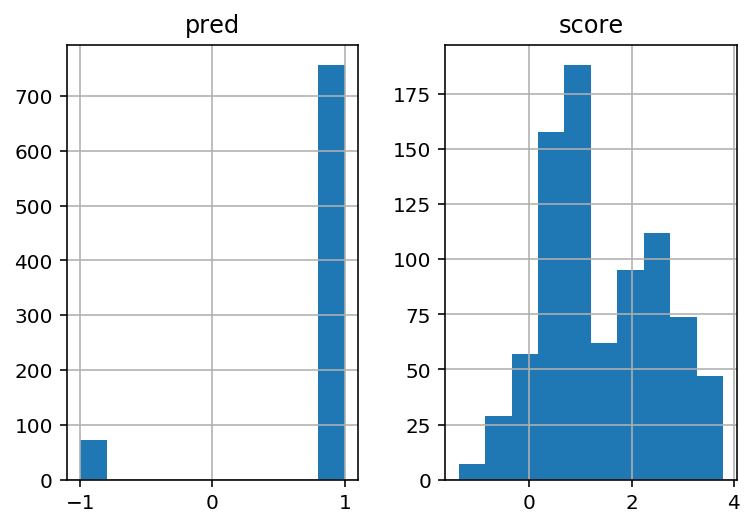

In [11]:
df.hist()

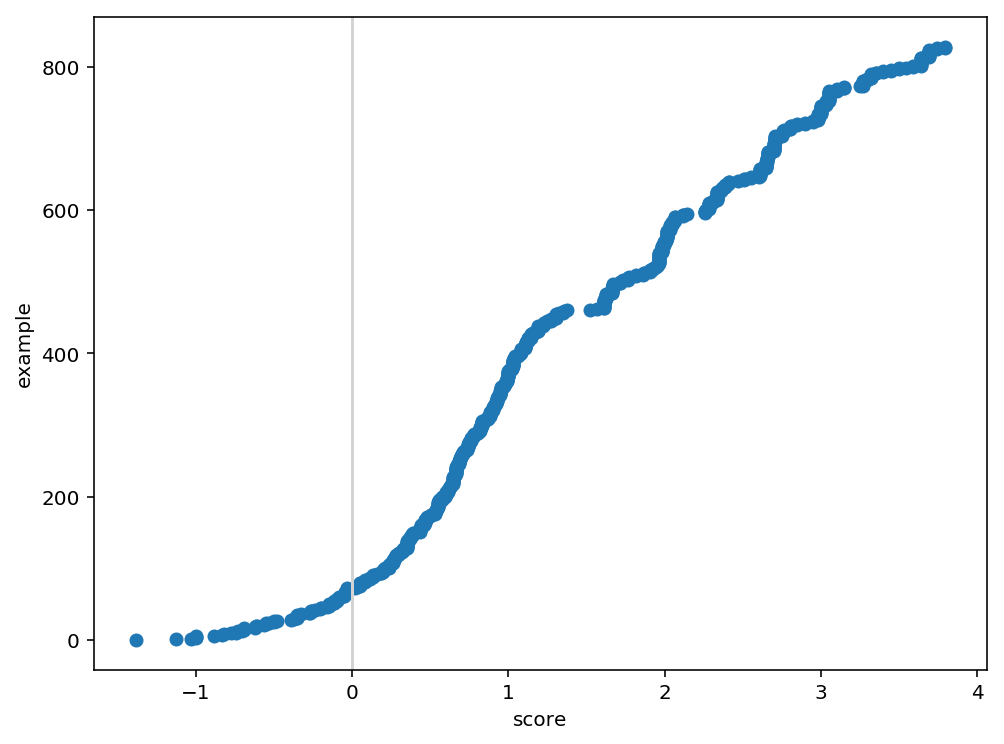

In [12]:
sorted_df = df.sort_values('score')
sorted_df = sorted_df.reset_index();

plt.figure(figsize=(8,6))
plt.scatter(x=sorted_df.score, y=sorted_df.index)
plt.xlabel('score')
plt.ylabel('example')
plt.axvline(0, color='lightgrey')

Text(0,0.5,'prediction')

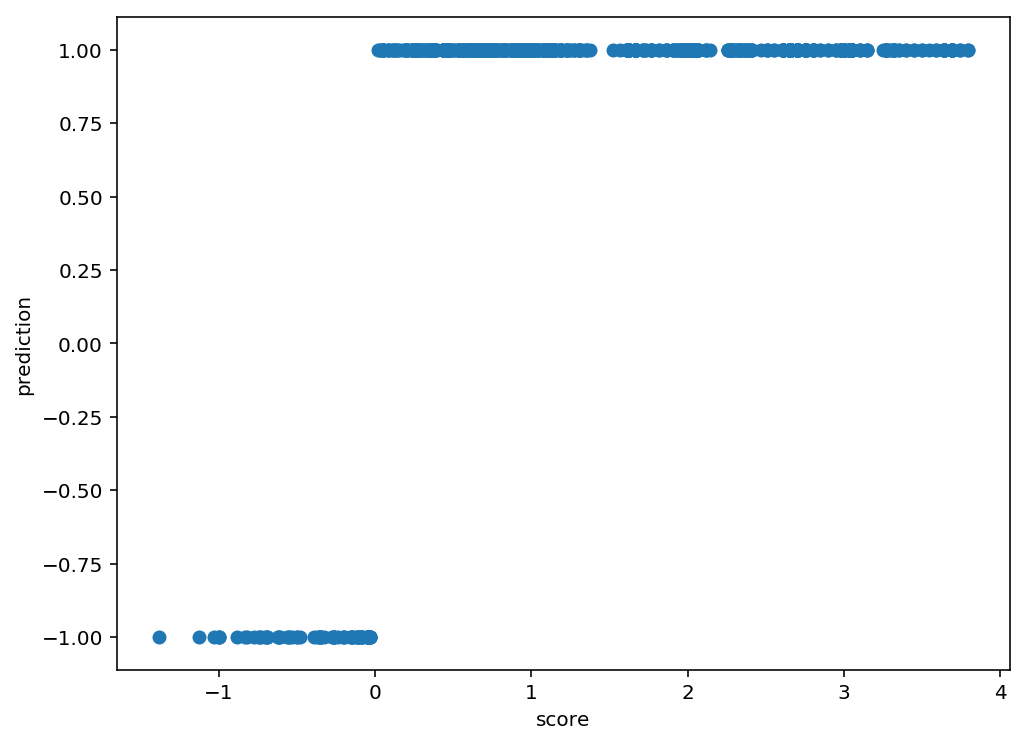

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(x=df.score, y=df.pred)
plt.xlabel('score')
plt.ylabel('prediction')

/usr/local/anaconda3/envs/asp/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Text(0,0.5,'label/loss')

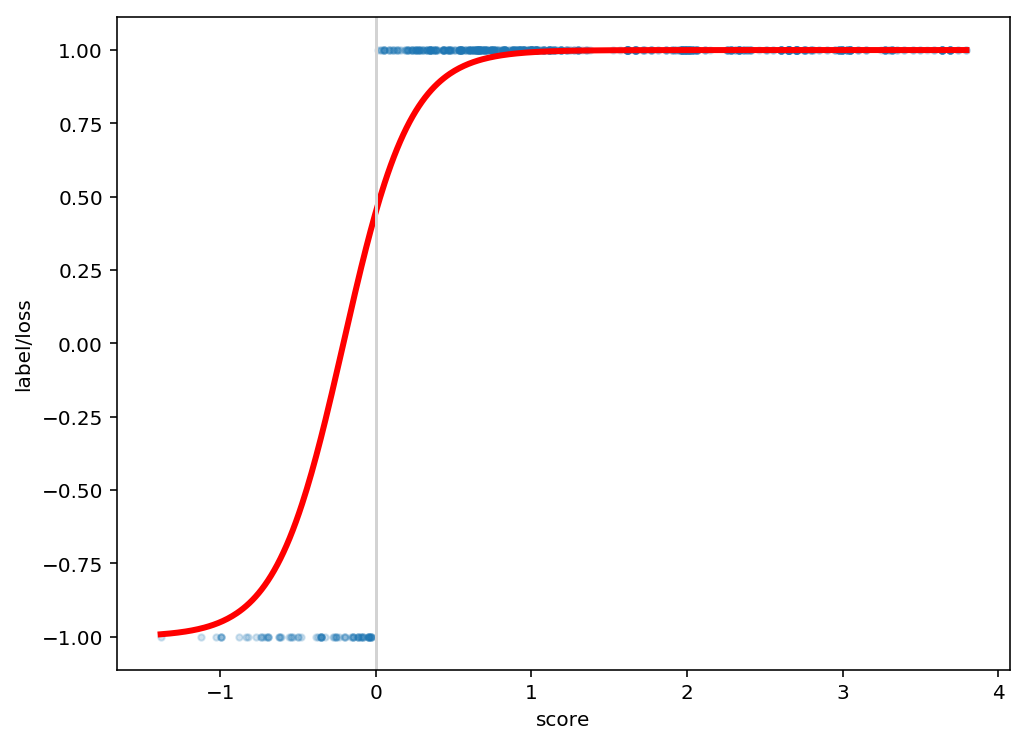

In [14]:
from sklearn.linear_model import LogisticRegression

score = df.pred.values.reshape(len(df.score), 1)
pred = df.pred.values.reshape(len(df.pred), 1)

logreg = LogisticRegression()
logreg.fit(X=score, y=pred)

resolution = 0.01
score_sample = np.arange(df.score.min(), df.score.max()+resolution, resolution)

def model(x):
    return 2 / (1 + np.exp(-x)) - 1
loss = model(score_sample * logreg.coef_ + logreg.intercept_).ravel()

plt.figure(figsize=(8,6))
plt.plot(score_sample, loss, color='red', linewidth=3)
plt.scatter(x=df.score, y=df.pred, alpha=0.2, s=10)
plt.axvline(0, color='lightgrey')
plt.xlabel('score')
plt.ylabel('label/loss')

## Explain the wrong predictions

In [15]:
df['task'] = data.task
df['source'] = data.source

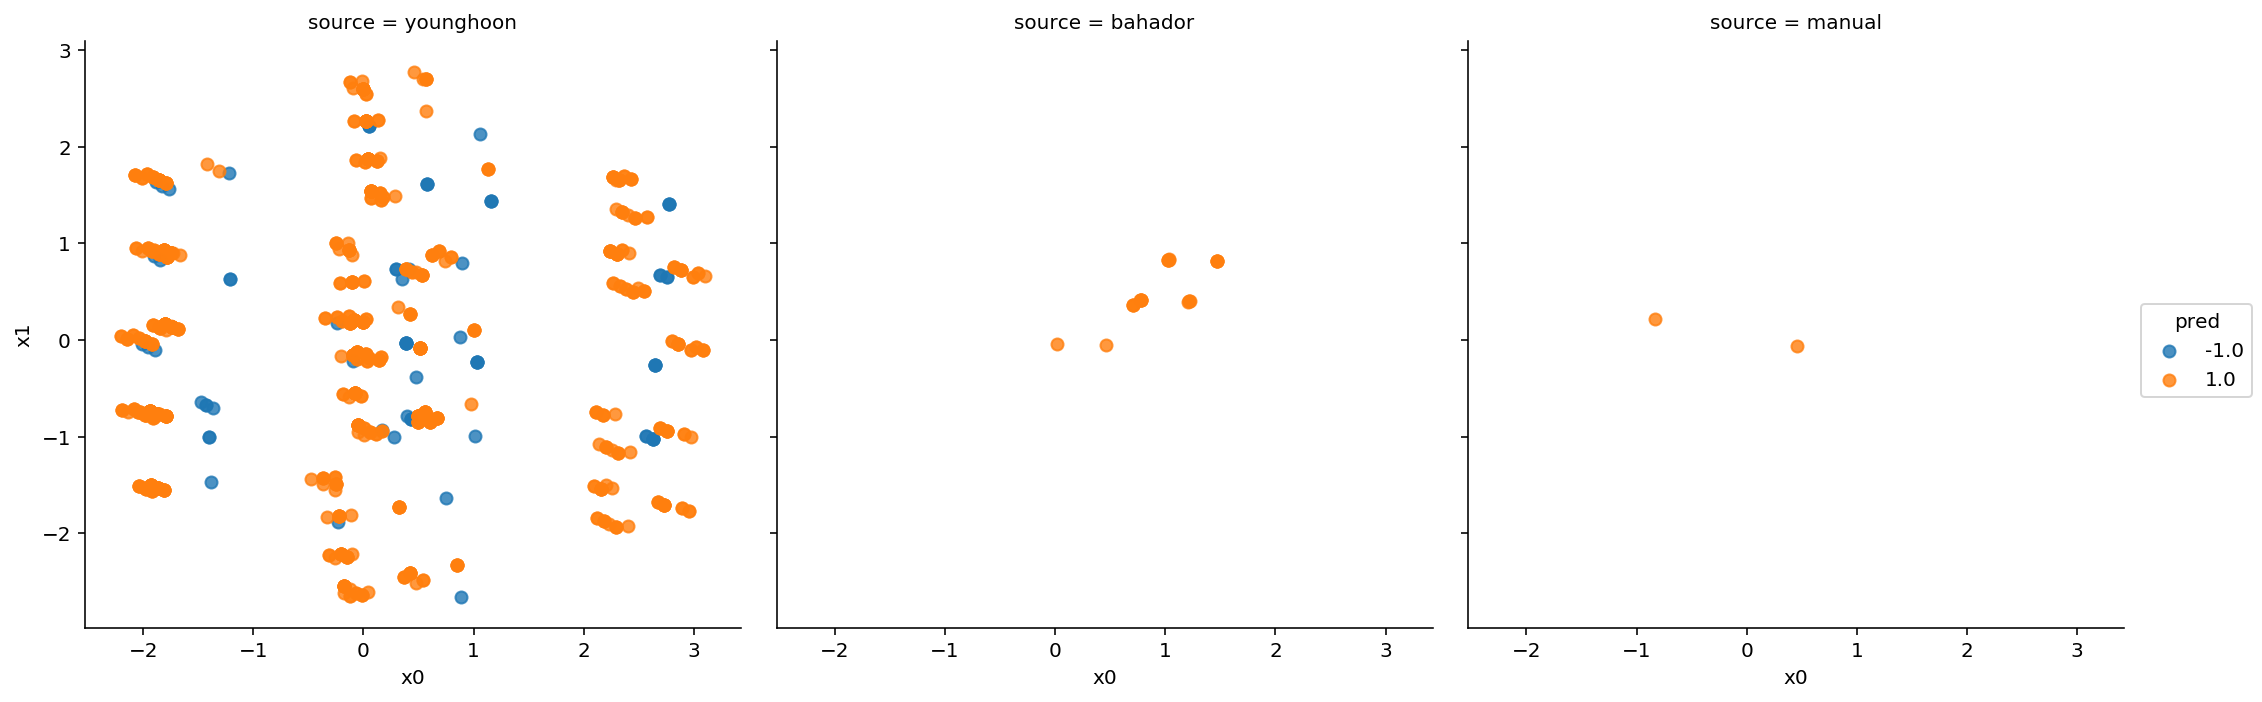

In [16]:
pca = PCA(2)
pca_df = pd.DataFrame(pca.fit_transform(X), index=X.index, columns=['x0', 'x1'])
pca_df = pd.concat([pca_df, df], axis=1)

sns.lmplot(x='x0', y='x1', hue='pred', col='source', data=pca_df, fit_reg=False)

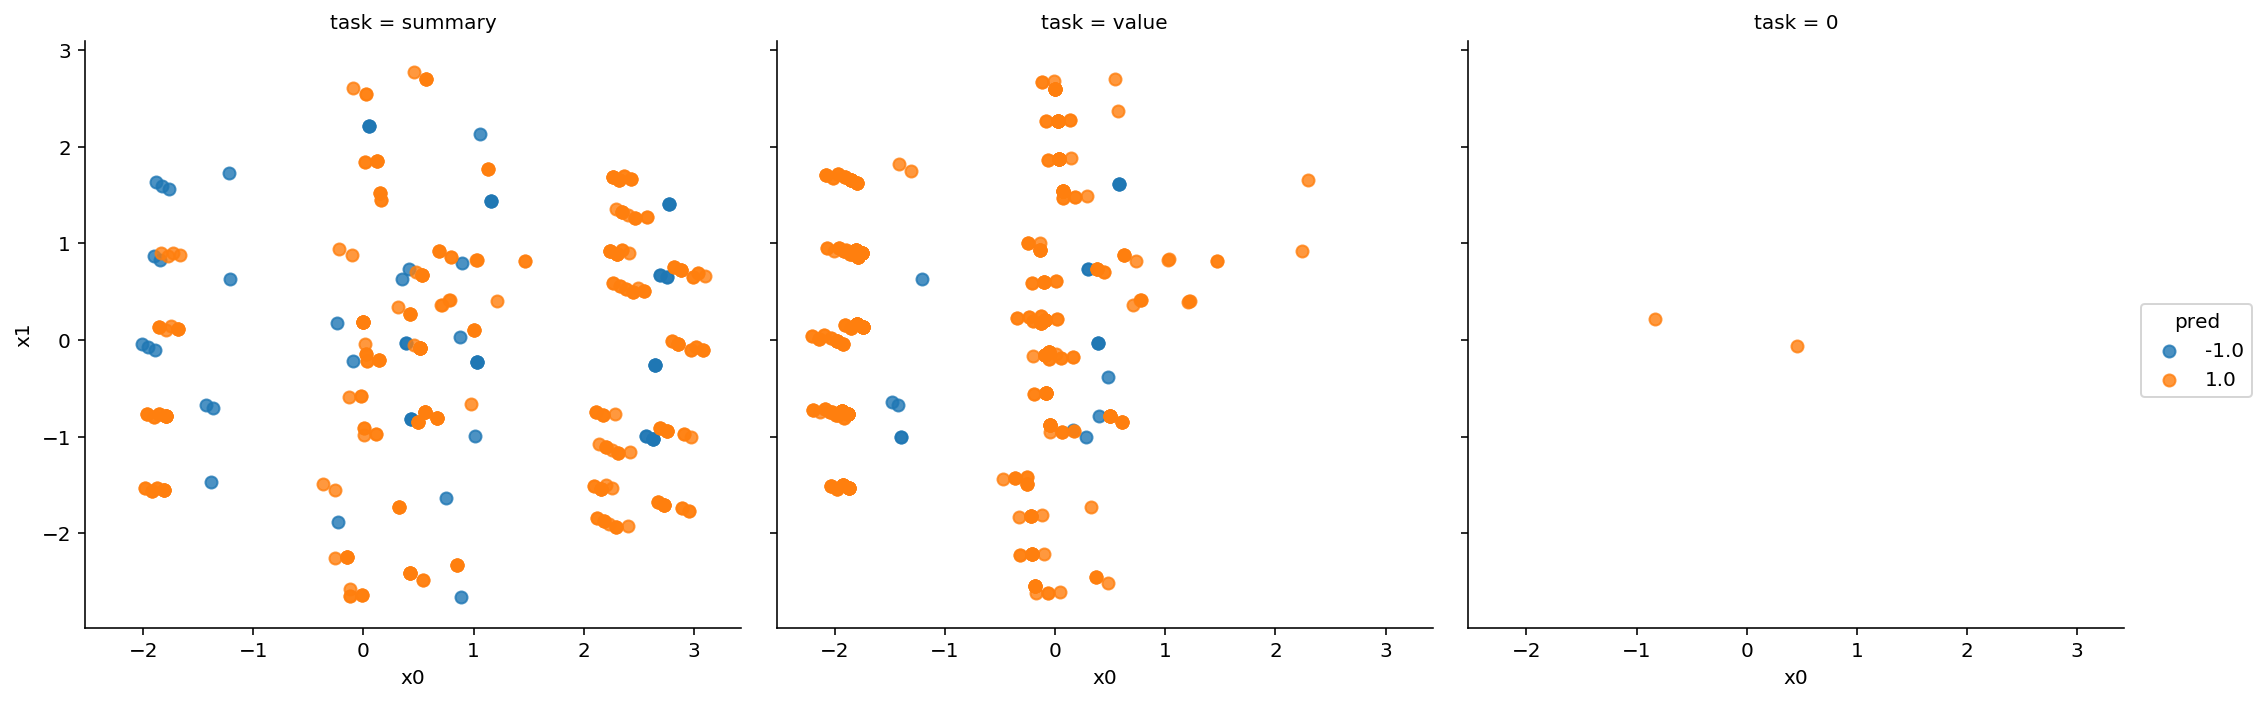

In [17]:
sns.lmplot(x='x0', y='x1', hue='pred', col='task', data=pca_df, fit_reg=False)

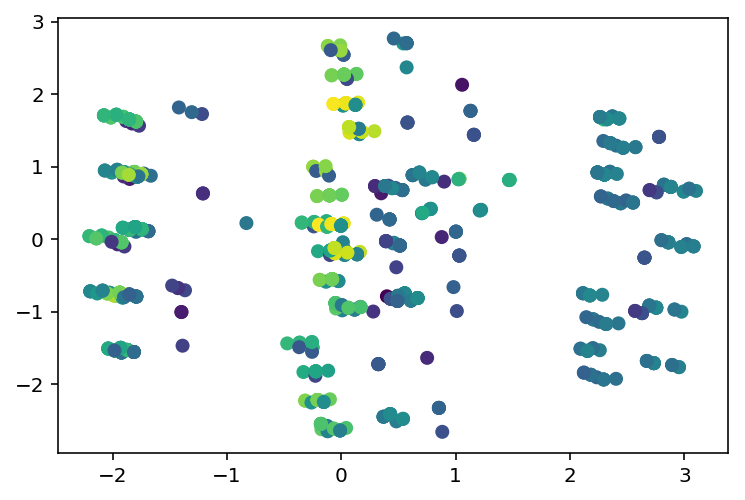

In [18]:
plt.scatter(x=pca_df.x0, y=pca_df.x1, c=pca_df.score, data=pca_df)

In [19]:
# leverage scores

X = X.sort_index()

u, s, vh = np.linalg.svd(X, full_matrices=False)
lev_scores = np.sum(u*u, axis=1)

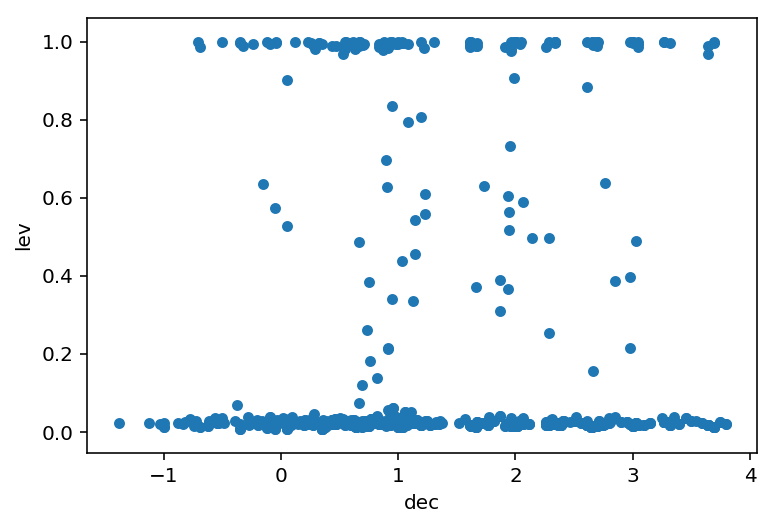

In [20]:
dec_fct = clf.decision_function(X)

scores_dec_fct = pd.DataFrame({'dec': dec_fct, 'lev': lev_scores})
scores_dec_fct = scores_dec_fct.sort_values('dec')

scores_dec_fct.plot.scatter(x='dec', y='lev')

## Plot all feature vectors

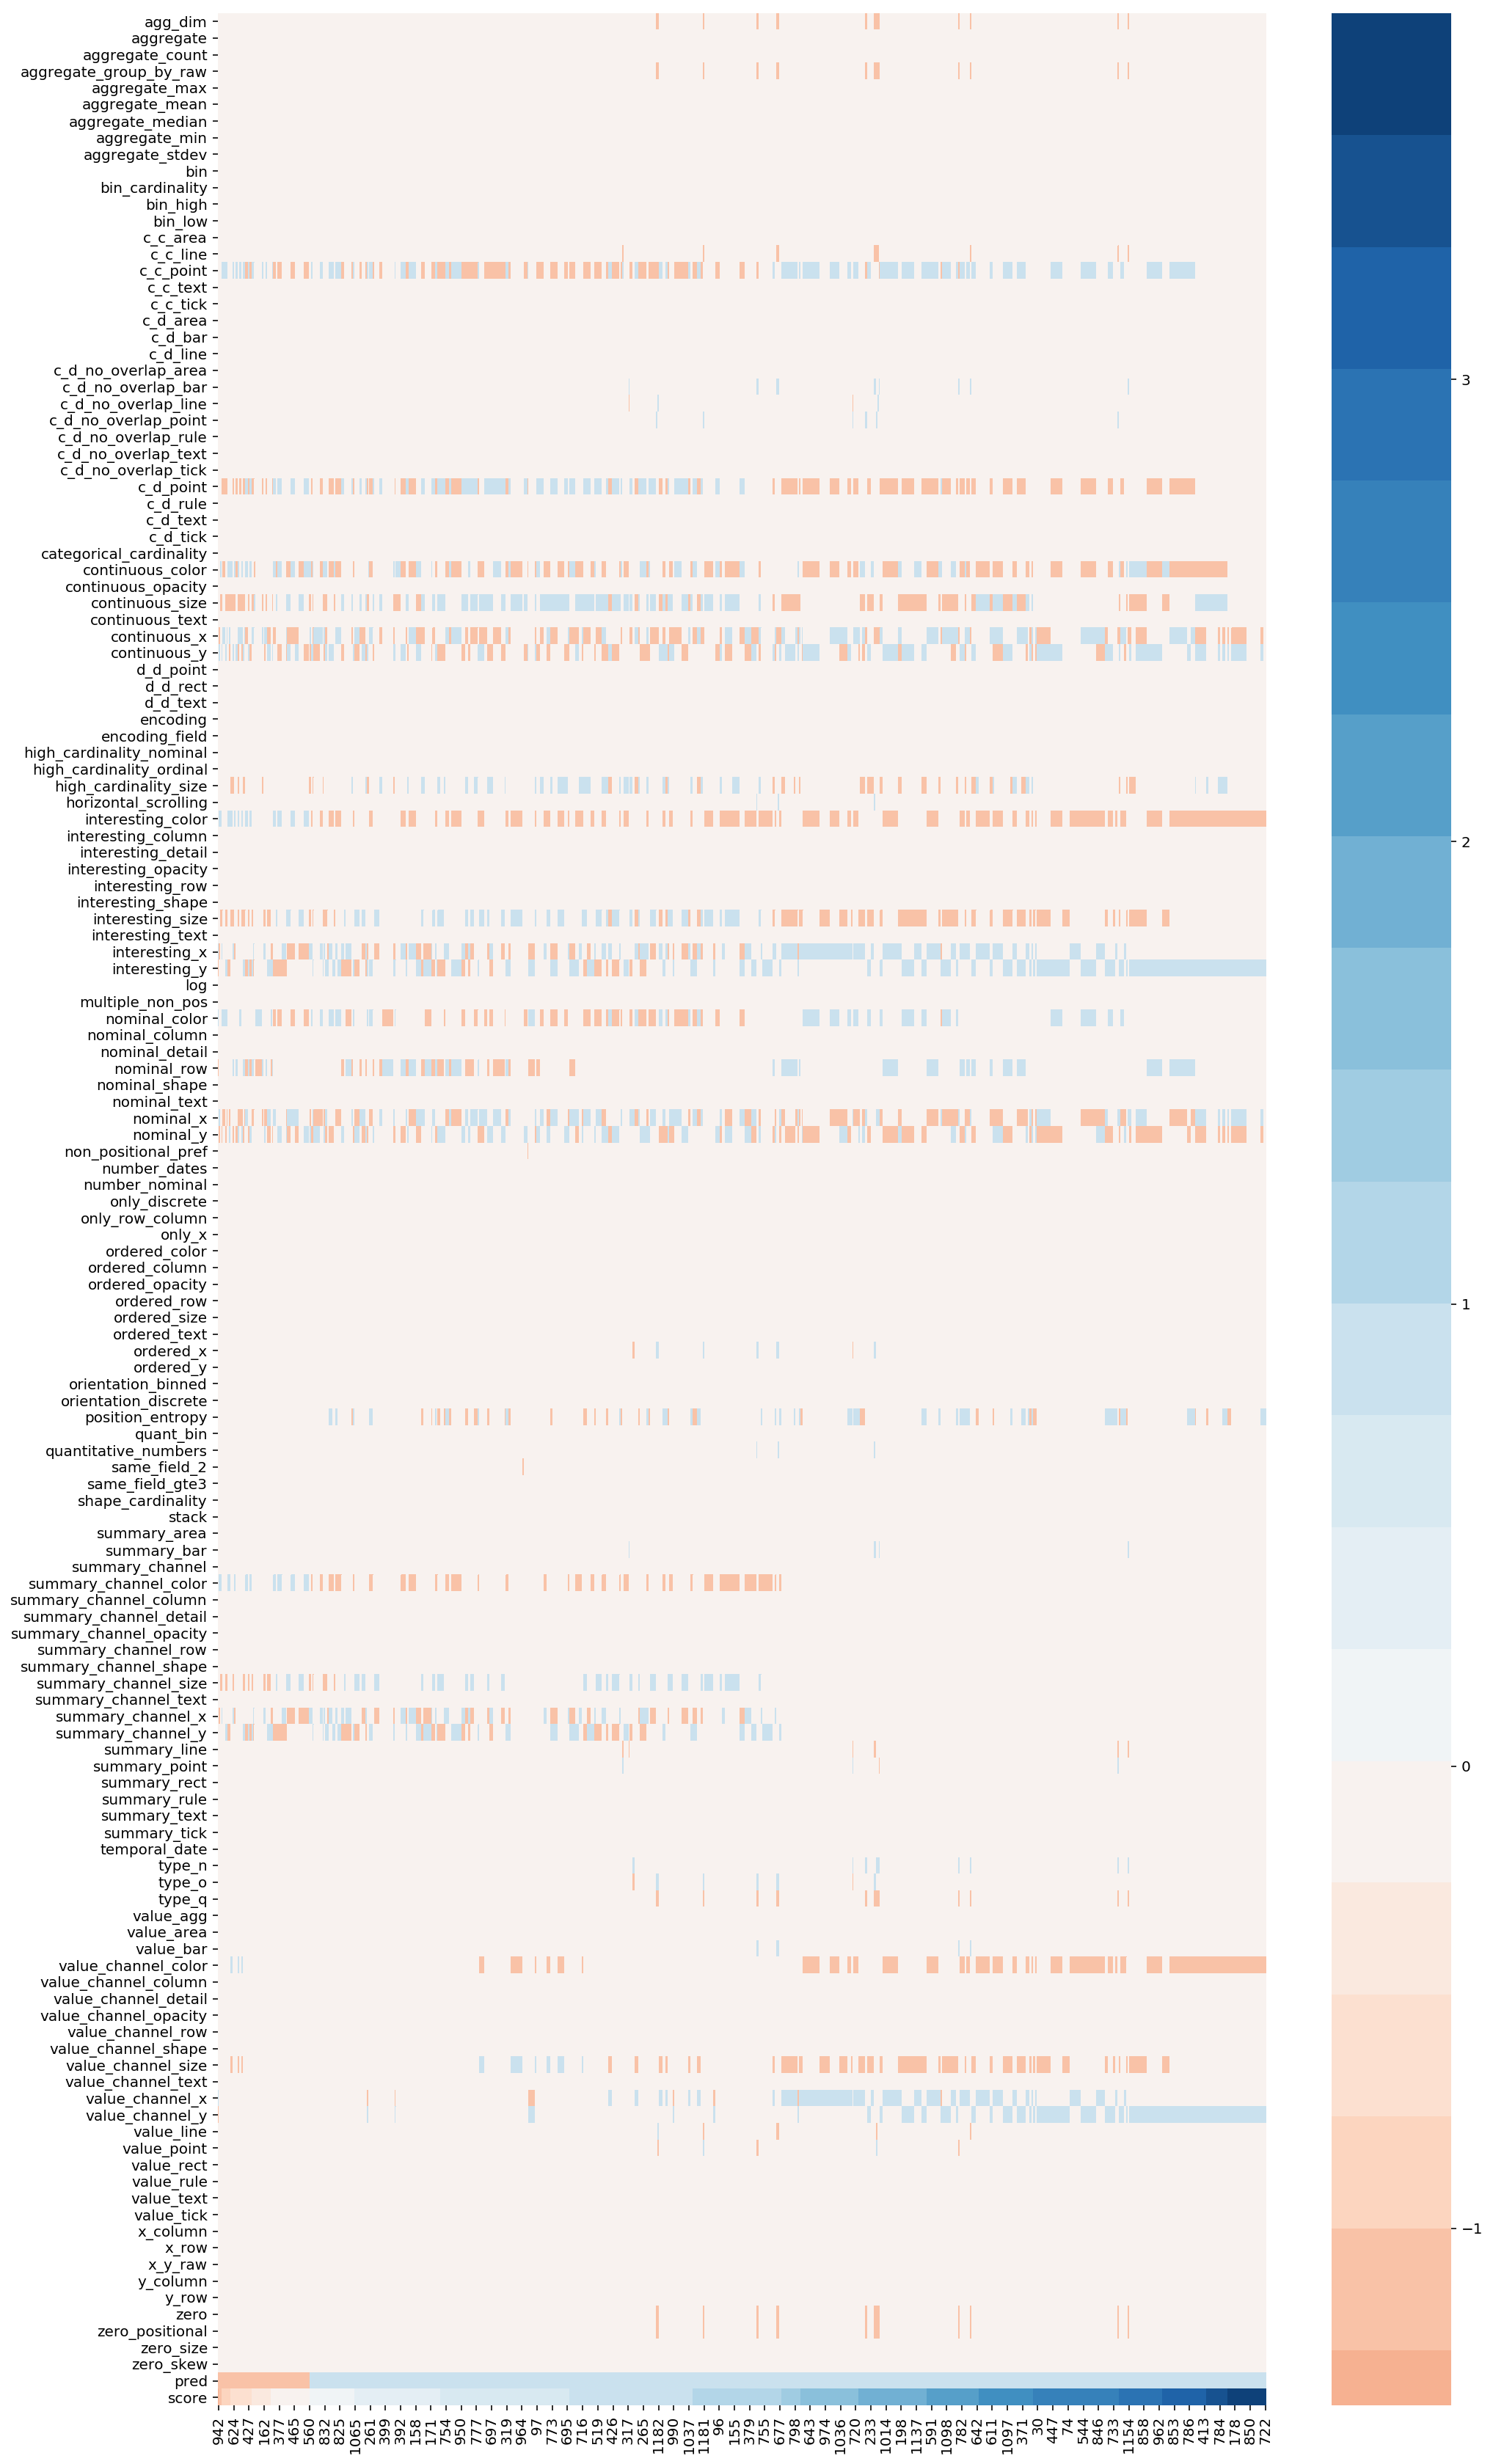

In [21]:
labeled_df = X.copy()
labeled_df['pred'] = clf.predict(X)
labeled_df['score'] = clf.decision_function(X)

labeled_df = labeled_df.sort_values('score')

f, ax = plt.subplots(figsize=(16, 30))

cmap = sns.color_palette("RdBu", 30)

sns.heatmap(labeled_df.T, cmap=cmap, center=0)

This is only a start but we might be able to see certain features that are always negative in the examples that are classified incorrectly. We need to look more at this.  

## Feature ranking

Here we look at the feature weights or some other metrics of importance of features.

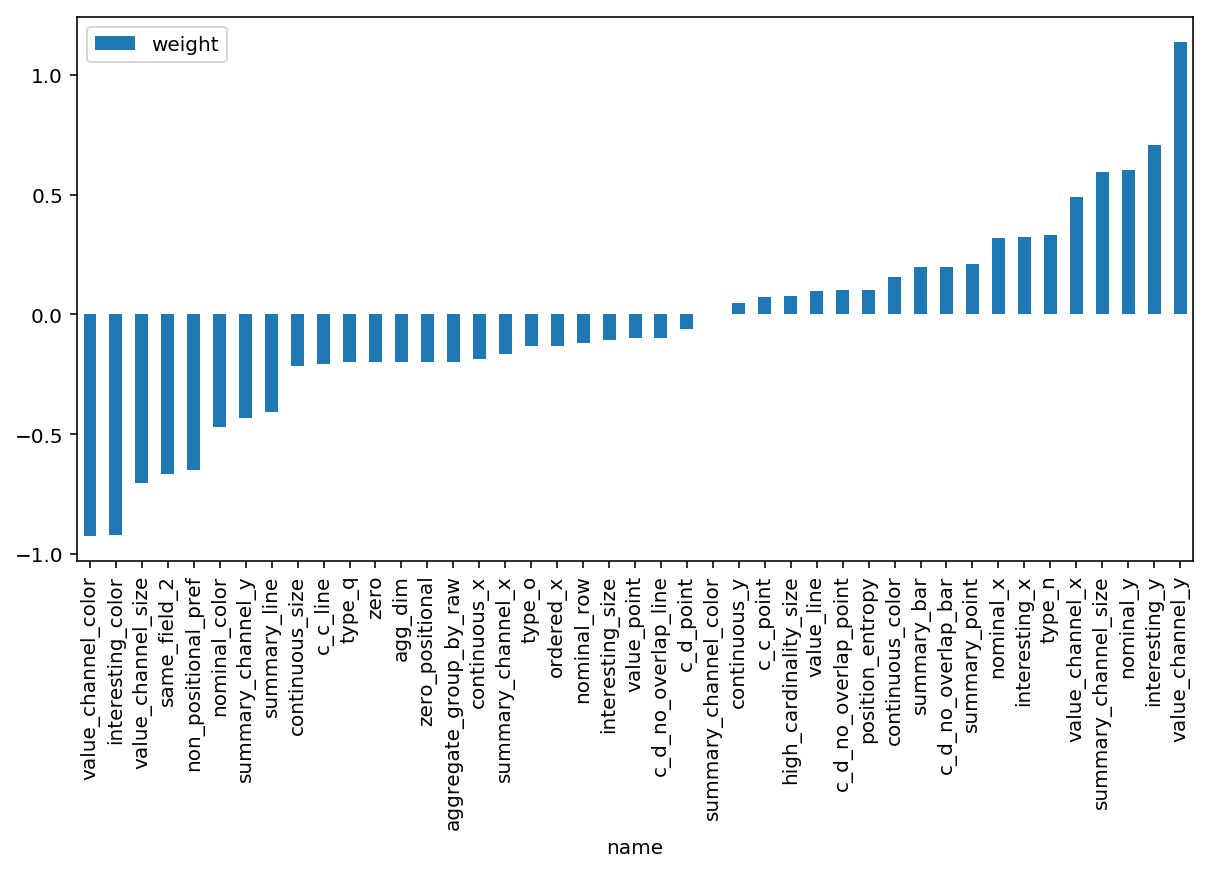

In [22]:
feat_df = pd.DataFrame({'name': X.columns, 'weight': clf.coef_[0]})
interesting_feat_df = feat_df[feat_df.weight != 0].sort_values('weight')
interesting_feat_df.plot.bar(x='name', figsize=(10, 5))